The work in this file has been refernced from https://www.youtube.com/watch?v=IHq1t7NxS8k and https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet

Importing the Dependencies

In [ ]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision.transforms.functional as TF

In [ ]:
#Model creation that does what unet does except that each double convolution produces feature maps of the same size, to avoid confusion during skip connections

class double_convolution(nn.Module):
  def __init__(self,in_features,out_features):
    super().__init__()
    self.first_conv=nn.Conv2d(in_features,out_features,3,1,1)
    self.second_conv=nn.Conv2d(out_features,out_features,3,1,1)
    self.batch_norm=nn.BatchNorm2d(out_features)
    self.relu=nn.ReLU(inplace=True)

  def forward(self,x):
    x=self.first_conv(x)
    x=self.batch_norm(x)
    x=self.relu(x)
    x=self.second_conv(x)
    x=self.batch_norm(x)
    x=self.relu(x)
    return x


class UNET(nn.Module):
  def __init__(self,in_channels=3,out_channels=1,feature_maps=[64,128,256,512]):
    super().__init__()
    self.downs=nn.ModuleList()
    self.ups=nn.ModuleList()
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

    for i in range(len(feature_maps)):
      self.downs.append(double_convolution(in_channels,feature_maps[i]))
      in_channels=feature_maps[i]

    for feature in reversed(feature_maps):
      self.ups.append(nn.ConvTranspose2d(2*feature,feature,kernel_size=2,stride=2))
      self.ups.append(double_convolution(2*feature,feature))

    self.final_conv=nn.Conv2d(feature_maps[0],out_channels,kernel_size=1,stride=1)

    self.bottleneck=double_convolution(feature_maps[-1],2*feature_maps[-1])

  def forward(self,x):
    skip_connections=[]  #List of 3d tensors that have the values for skip connections

    for down in self.downs:
      x=down(x)
      skip_connections.append(x)
      x=self.pool(x)

    x=self.bottleneck(x)

    skip_connections=skip_connections[::-1]

    for i,up in enumerate(self.ups):
      if (i%2==0):
        x=up(x)
        #then concat here at this point
        to_concat=skip_connections[i//2]


        if (to_concat.shape != x.shape):
          x=TF.resize(x,size=to_concat.shape[2:])

        x=torch.cat((to_concat,x),dim=1)

      else:
        x=up(x)

    # print(x.shape)

    x=self.final_conv(x)

    return x


#ONE MAJOR ISSUE HERE

'''
If we take the image like we did those guys in unet did, which is 572X572
There are four red arrows meaning that down_sampling is done 4 times
And if 143X143 is down_Sampled then the resulting skip_connection would be 71X71,
 and when recreated on the other side, the image would be 142X142 and the skip connections wouldn't concat

But i have solved this problem by resizing the x on the other side to match the shape of the incoming skip_connection
'''


"\nIf we take the image like we did those guys in unet did, which is 572X572\nThere are four red arrows meaning that down_sampling is done 4 times\nAnd if 143X143 is down_Sampled then the resulting skip_connection would be 71X71,\n and when recreated on the other side, the image would be 142X142 and the skip connections wouldn't concat\n\nBut i have solved this problem by resizing the x on the other side to match the shape of the incoming skip_connection\n"

In [ ]:
def test():
  x=torch.randn(3,3,172,172)
  print("Original_image_shape:",x.shape)
  unet=UNET(in_channels=3,out_channels=1)
  x=unet(x)

  print("Output_image_shape:",x.shape)

test()

Original_image_shape: torch.Size([3, 3, 172, 172])
Output_image_shape: torch.Size([3, 1, 172, 172])


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

# Define custom transformation function to apply transforms to both image and mask
class SegmentationTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, img, target):
        img = self.base_transform(img)
        target = self.base_transform(target)
        return img, target

# Set up base transformations for resizing and converting to tensor
base_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Apply custom transformation to both image and mask
transform = SegmentationTransform(base_transform)

# Load the training dataset
train_dataset = datasets.VOCSegmentation(
    root="VOC2",
    year="2012",
    image_set="train",
    download=True,
    transforms=transform
)

# Load the validation dataset (can serve as a test set)
val_dataset = datasets.VOCSegmentation(
    root="VOC2",
    year="2012",
    image_set="val",
    download=True,
    transforms=transform
)

batch_size = 16  # Adjust based on GPU memory


100%|██████████| 2.00G/2.00G [01:04<00:00, 30.9MB/s]


Extracting VOC2/VOCtrainval_11-May-2012.tar to VOC2
Using downloaded and verified file: VOC2/VOCtrainval_11-May-2012.tar
Extracting VOC2/VOCtrainval_11-May-2012.tar to VOC2


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True
)

In [ ]:
model=UNET(3,21)

In [ ]:
# Training function
def train_one_epoch(model, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    i=0
    for images, masks in dataloader:
        i+=1
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

        # Compute the loss
        masks = masks.squeeze(1).long()  # This will reduce the channel dimension

        print("Outputs shape:", outputs.shape)
        print("Outputs dtype:",outputs.dtype)
        print("Masks shape:", masks.shape)
        print("Masks dtype:", masks.dtype)


        loss = F.cross_entropy(outputs, masks)  # Ensure masks are long (integer) type
        running_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print("Running_loss_while_training:", running_loss / (16*i))

In [ ]:

# Testing function
def test_one_epoch(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    i=0
    with torch.no_grad():
        for images, masks in dataloader:
            i+=1
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            masks = masks.squeeze(1).long()
            # Compute the loss
            loss = F.cross_entropy(outputs, masks.long())
            running_loss += loss.item()

            print("Running_loss_while_eval:", running_loss / (16*i))

In [ ]:

# Example training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Assuming you have defined your model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:

num_epochs = 1
for epoch in range(num_epochs):
    print("Epoch number:",epoch+1)
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = test_one_epoch(model, val_loader, device)

    # print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch number: 1
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.17636147141456604
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.1753496304154396
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.17417788008848825
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.17337043955922127
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.1725941002368927
Outputs shape: torch.Size([16, 21, 256, 2

In [ ]:
torch.save(model,"unet_model.pth")

In [ ]:
torch.save(model.state_dict(),"unet_model_weights.pth")

In [ ]:

num_epochs = 3
for epoch in range(num_epochs):
    print("Epoch number:",epoch+1)
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = test_one_epoch(model, val_loader, device)

    # print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch number: 1
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.11127929389476776
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.1110796146094799
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.11098120113213857
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.11116487346589565
Outputs shape: torch.Size([16, 21, 256, 256])
Outputs dtype: torch.float32
Masks shape: torch.Size([16, 256, 256])
Masks dtype: torch.int64
Running_loss_while_training: 0.11109195798635482
Outputs shape: torch.Size([16, 21, 256, 

In [ ]:
torch.save(model.state_dict(),"unet_model_weights_v1.1.pth")

Trying to test on individual data items

<ipython-input-8-63505d1a9967>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Data/unet_model_wei

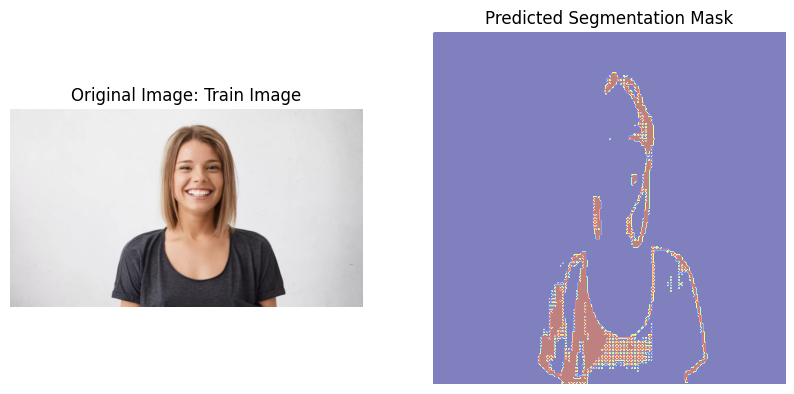

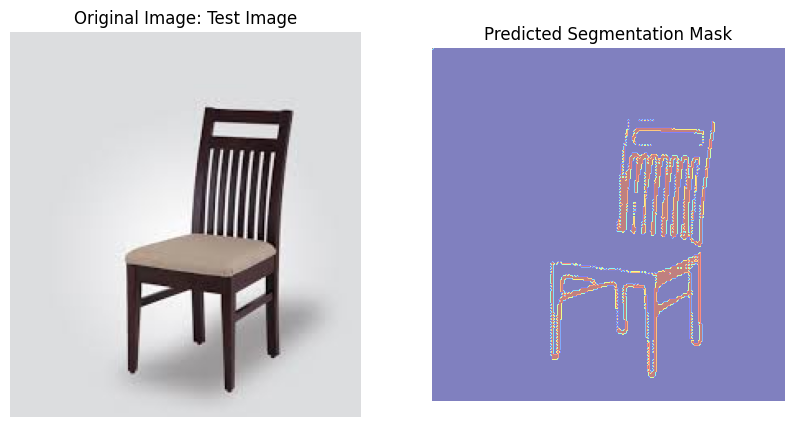

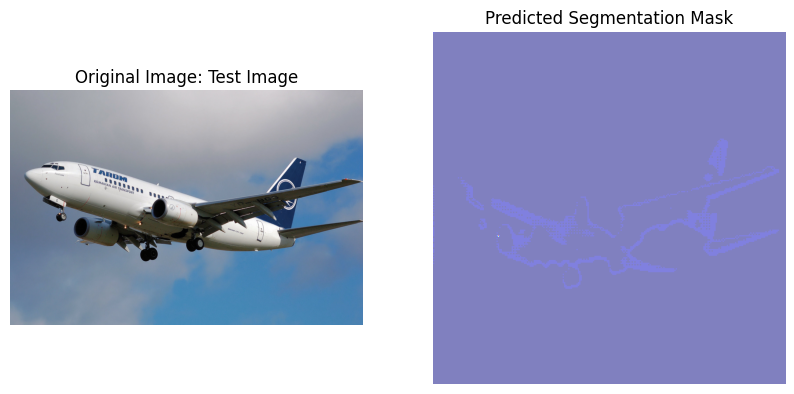

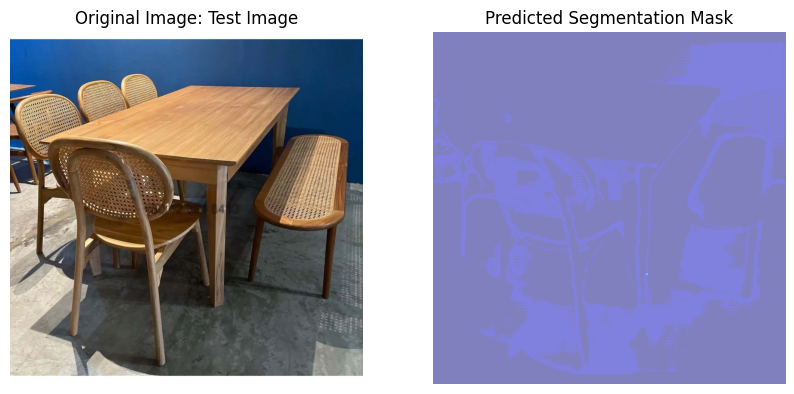

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Assuming you have a trained model and a DataLoader for the test dataset
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model (make sure the model architecture matches)
model = UNET(3,21)  # Replace with your model class
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Data/unet_model_weights_v1.1.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Function to process and predict an image
def predict_and_display(image_path, title):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Define the transformations (same as during training)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Adjust size if necessary
        transforms.ToTensor(),
    ])

    # Transform the image
    input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Run the model
    with torch.no_grad():
        output = model(input_image)  # Shape: [1, num_classes, 256, 256]

    # Get the predicted mask (use argmax to get the class index)
    output_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: [256, 256]

    # Display the image and the predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image: {title}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(output_mask, cmap='jet', alpha=0.5)  # Overlay the predicted mask
    plt.title("Predicted Segmentation Mask")
    plt.axis('off')

    plt.show()

# Test on an image from the training dataset
train_image_path = "/content/shutterstock_648907024.webp"  # Replace with an actual train image path
predict_and_display(train_image_path, "Train Image")

# Test on an image from the test dataset
test_image_path = "/content/images.jpg"  # Replace with an actual test image path
predict_and_display(test_image_path, "Test Image")

test_image_path = "/content/Tarom.b737-700.yr-bgg.arp.jpg"  # Replace with an actual test image path
predict_and_display(test_image_path, "Test Image")

test_image_path = "/content/rattan_teak_dining_set_with_bench1-transformed.webp"  # Replace with an actual test image path
predict_and_display(test_image_path, "Test Image")
